
Multimodal Diagnosis Pipeline (All Modalities)



In [1]:

# === CONFIG ===
from pathlib import Path
# Fused dataset path (Excel/CSV) with PTID, Diagnosis, and features
DATA_PATH = Path("/Users/madhurabn/Desktop/adni/data/processed/fusion_master.xlsx")

PTID_COL = "PTID"        # id column (case-insensitive resolution)
LABEL_COL = "Diagnosis"  # label column (case-insensitive resolution)

# Feature selection budget
K_BEST = 60               # ANOVA top-K per fold

# Evaluation setup
RANDOM_STATE = 42
N_SPLITS = 5
TEST_SIZE = 0.20

# Outputs
OUTDIR = Path("/Users/madhurabn/Desktop/adni/output/Diagnosis_All modalities")
PLOTDIR = OUTDIR
OUTDIR.mkdir(parents=True, exist_ok=True)
PLOTDIR.mkdir(parents=True, exist_ok=True)

print("Outputs ->", OUTDIR.resolve())


Outputs -> /Users/madhurabn/Desktop/adni/output/Diagnosis_All modalities


In [2]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, classification_report,
                             confusion_matrix, RocCurveDisplay)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline


In [3]:

# === Load fused dataset ===
def _read_any(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Not found: {path}")
    if path.suffix.lower() in [".xlsx", ".xls"]:
        return pd.read_excel(path)
    return pd.read_csv(path)

df = _read_any(DATA_PATH).copy()

# Resolve PTID/Diagnosis column names case-insensitively
def _resolve_col(df, candidates):
    low = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in low:
            return low[cand.lower()]
    return None

ptid_col = _resolve_col(df, [PTID_COL, "ptid", "rid", "subject"])
label_col = _resolve_col(df, [LABEL_COL, "diagnosis", "label", "group", "dx", "dx_bl"])
assert label_col is not None, "Diagnosis/label column not found."
print("Columns ->", {"PTID": ptid_col, "Diagnosis": label_col})

# Build X (numeric features only) and y
drop_cols = [c for c in df.columns if c.lower() in {str(ptid_col).lower(), str(label_col).lower(), "visit"}]
X_all = df.drop(columns=drop_cols, errors="ignore").select_dtypes(include=["number"]).copy()
y_raw = df[label_col].astype(str).values

le = LabelEncoder()
y_all = le.fit_transform(y_raw)
classes = list(le.classes_)
print("Classes:", classes)
print("X_all shape:", X_all.shape)


Columns -> {'PTID': 'ptid', 'Diagnosis': 'diagnosis'}
Classes: ['CN', 'DEMENTIA', 'MCI']
X_all shape: (745, 116)


In [4]:

# === Train/Test split (80/20) ===
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, stratify=y_all, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (596, 116)  Test: (149, 116)


In [5]:

def evaluate_model(name, estimator, k_best=K_BEST, random_state=RANDOM_STATE):
    """Leakage-safe evaluation:
    CV on train with pipeline [Scaler -> ADASYN -> ANOVA -> Estimator],
    then refit on full train and test on hold-out set.
    """
    pipe = ImbPipeline(steps=[
        ("scaler", StandardScaler()),
        ("adasyn", ADASYN(random_state=random_state)),
        ("anova",  SelectKBest(score_func=f_classif, k=min(k_best, X_train.shape[1]))),
        ("clf",    estimator),
    ])

    # Cross-validation (on training only)
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=random_state)
    scoring = {"accuracy":"accuracy", "f1_macro":"f1_macro", "roc_auc_ovr":"roc_auc_ovr"}
    cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

    # Refit on full 80% train and evaluate on 20% test
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    y_prob = None
    try:
        y_prob = pipe.predict_proba(X_test)
    except Exception:
        try:
            scores = pipe.decision_function(X_test)
            if scores.ndim == 1:
                from scipy.special import expit
                p1 = expit(scores)
                y_prob = np.vstack([1-p1, p1]).T
            else:
                e = np.exp(scores - scores.max(axis=1, keepdims=True))
                y_prob = e / e.sum(axis=1, keepdims=True)
        except Exception:
            pass

    results = {
        "Model": name,
        "CV Accuracy (mean)": float(np.mean(cv_res["test_accuracy"])),
        "CV Accuracy (SD)":   float(np.std(cv_res["test_accuracy"])),
        "CV Macro-F1 (mean)": float(np.mean(cv_res["test_f1_macro"])),
        "CV Macro-F1 (SD)":   float(np.std(cv_res["test_f1_macro"])),
        "CV ROC-AUC (OvR, macro)": float(np.mean(cv_res["test_roc_auc_ovr"])),
        "Test Accuracy": float(accuracy_score(y_test, y_pred)),
        "Test Macro-F1": float(f1_score(y_test, y_pred, average="macro")),
        "Test ROC-AUC (OvR, macro)": float(roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")) if y_prob is not None else np.nan,
    }

    # Save confusion matrix (test)
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    cm_path = PLOTDIR / f"{name.replace(' ','_')}_confusion_matrix_test.csv"
    cm_df.to_csv(cm_path)

    # Plot confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Greens")
    plt.title(f"{name} — Confusion Matrix (Test)"); plt.ylabel("True"); plt.xlabel("Predicted")
    png_cm = PLOTDIR / f"{name.replace(' ','_')}_confusion_matrix_test.png"
    plt.tight_layout(); plt.savefig(png_cm, dpi=200); plt.show()

    # ROC curves
    if y_prob is not None:
        plt.figure(figsize=(6,5))
        for i, lab in enumerate(classes):
            RocCurveDisplay.from_predictions((y_test == i).astype(int), y_prob[:, i], name=f"{lab}")
        plt.plot([0,1],[0,1],'k--', lw=1)
        macro_auc = results["Test ROC-AUC (OvR, macro)"]
        plt.title(f"{name} — ROC Curves (Test)\nMacro-avg AUC={macro_auc:.3f}")
        png_roc = PLOTDIR / f"{name.replace(' ','_')}_roc_test.png"
        plt.tight_layout(); plt.savefig(png_roc, dpi=200); plt.show()

    # Detailed classification report
    rep = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
    pd.DataFrame(rep).T.to_csv(OUTDIR / f"{name.replace(' ','_')}_classification_report_test.csv")

    return results, pipe



=== SVM (RBF) ===


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


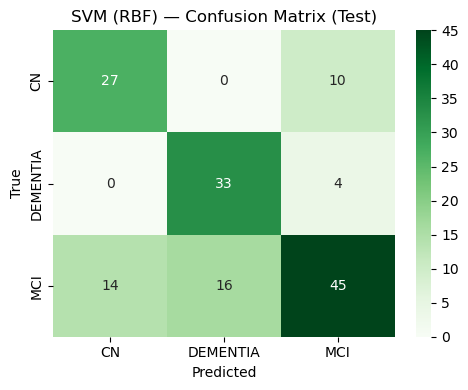

<Figure size 600x500 with 0 Axes>

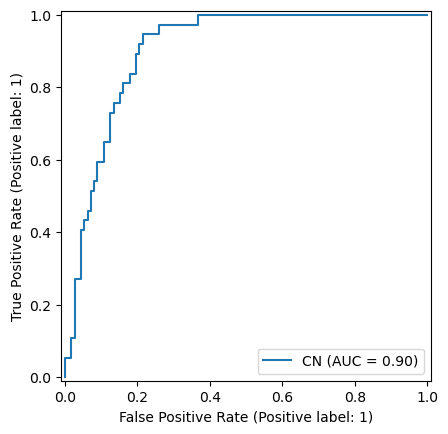

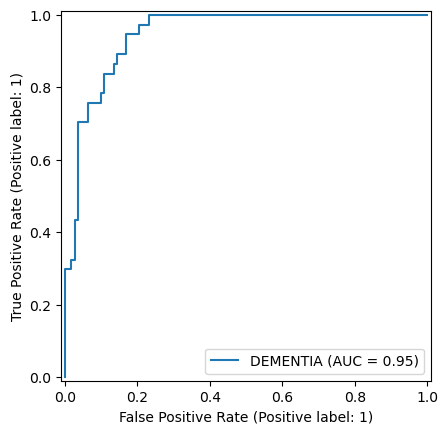

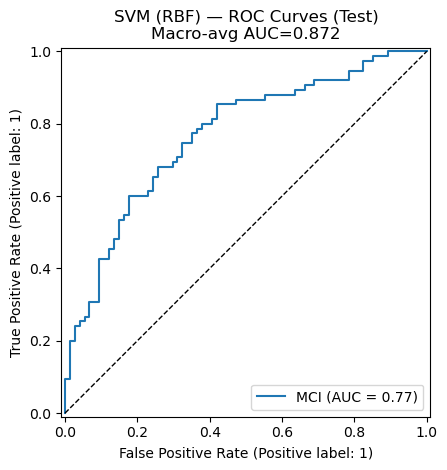


=== Random Forest ===


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


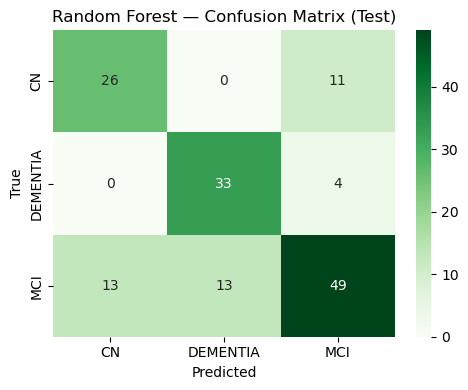

<Figure size 600x500 with 0 Axes>

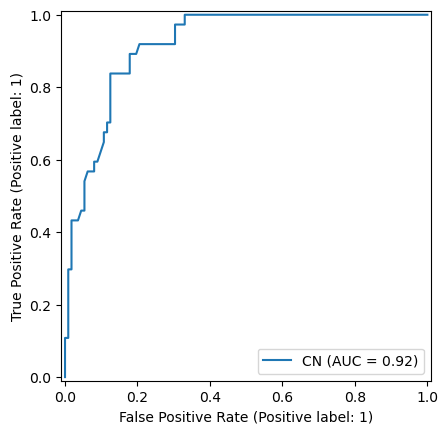

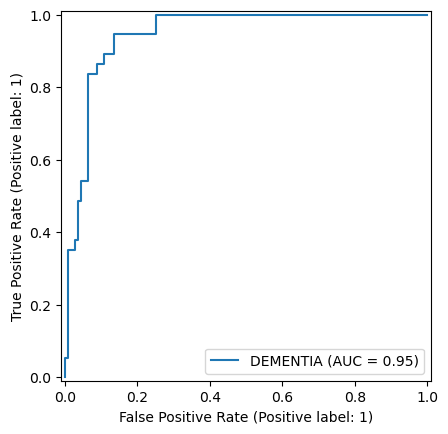

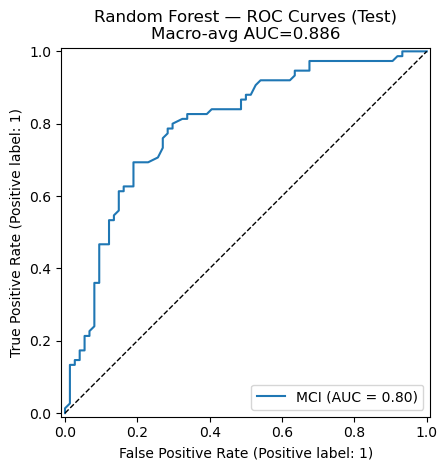


=== XGBoost ===


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


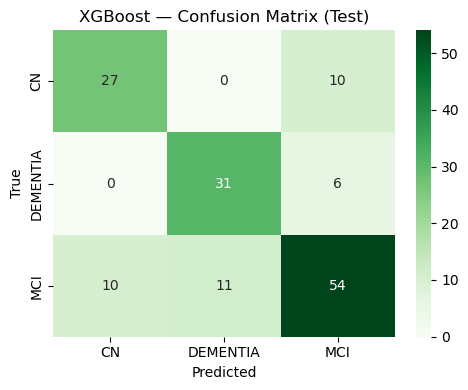

<Figure size 600x500 with 0 Axes>

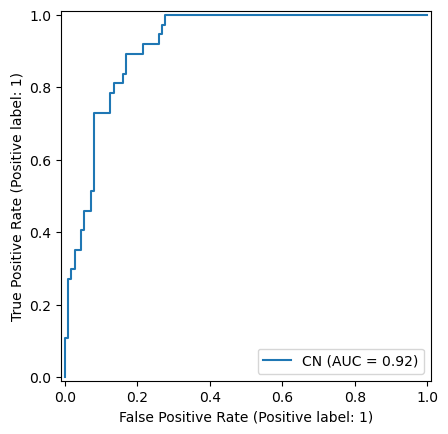

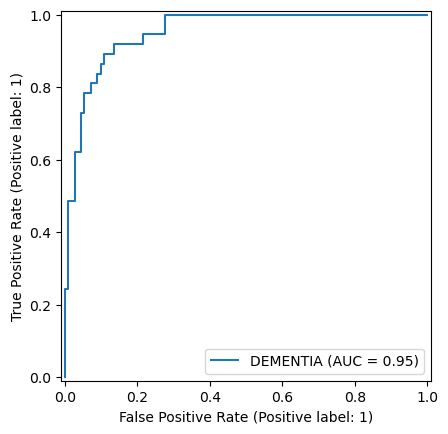

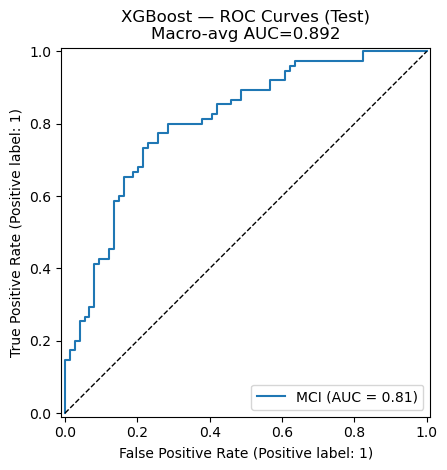


=== Stacking Ensemble ===


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 6 7 8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


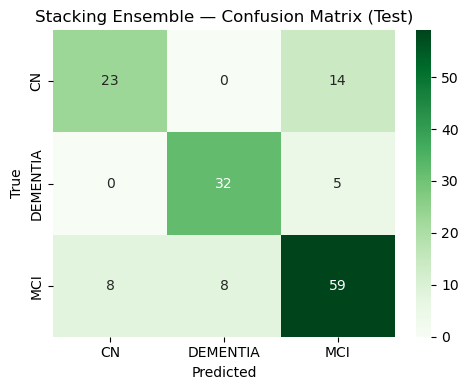

<Figure size 600x500 with 0 Axes>

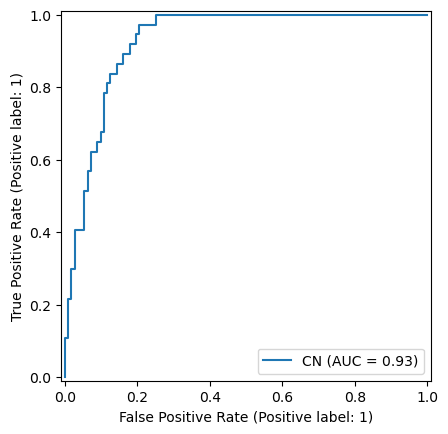

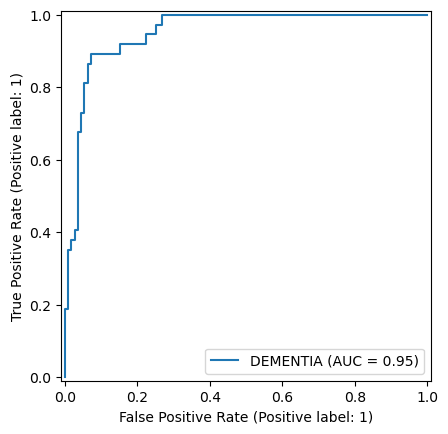

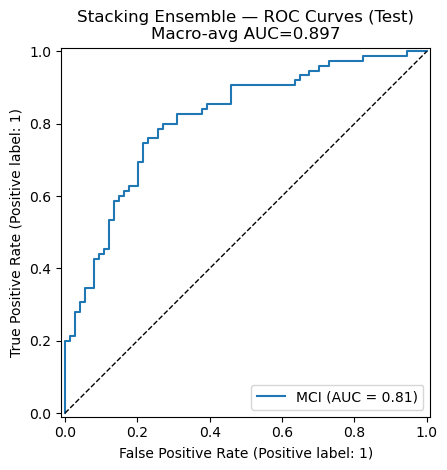

,Model,CV Accuracy (mean),CV Accuracy (SD),CV Macro-F1 (mean),CV Macro-F1 (SD),"CV ROC-AUC (OvR, macro)",Test Accuracy,Test Macro-F1,"Test ROC-AUC (OvR, macro)"
0,SVM (RBF),0.694636,0.014509,0.696417,0.011301,0.864627,0.704698,0.710464,0.872350
1,Random Forest,0.714804,0.033239,0.716685,0.030636,0.882820,0.724832,0.728142,0.886485
2,XGBoost,0.719804,0.035038,0.721756,0.032266,0.891424,0.751678,0.753122,0.892401
3,Stacking Ensemble,0.741611,0.036581,0.739051,0.037735,0.890535,0.765101,0.759627,0.897018


In [6]:

# === Models ===
svm_clf = SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)
rf_clf  = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE)
xgb_clf = XGBClassifier(
    n_estimators=500, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    objective="multi:softprob", eval_metric="mlogloss", random_state=RANDOM_STATE
)
stack_clf = StackingClassifier(
    estimators=[
        ("svm", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)),
        ("rf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE)),
        ("xgb", XGBClassifier(
            n_estimators=400, max_depth=5, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            objective="multi:softprob", eval_metric="mlogloss", random_state=RANDOM_STATE
        )),
    ],
    final_estimator=LogisticRegression(max_iter=2000, multi_class="auto", random_state=RANDOM_STATE),
    stack_method="predict_proba", passthrough=False
)

models = [
    ("SVM (RBF)", svm_clf),
    ("Random Forest", rf_clf),
    ("XGBoost", xgb_clf),
    ("Stacking Ensemble", stack_clf),
]

results = []
trained = {}
for name, clf in models:
    print(f"\n=== {name} ===")
    res, pipe = evaluate_model(name, clf)
    results.append(res)
    trained[name] = pipe

results_df = pd.DataFrame(results)
results_df.to_csv(OUTDIR / "model_results_summary.csv", index=False)
results_df


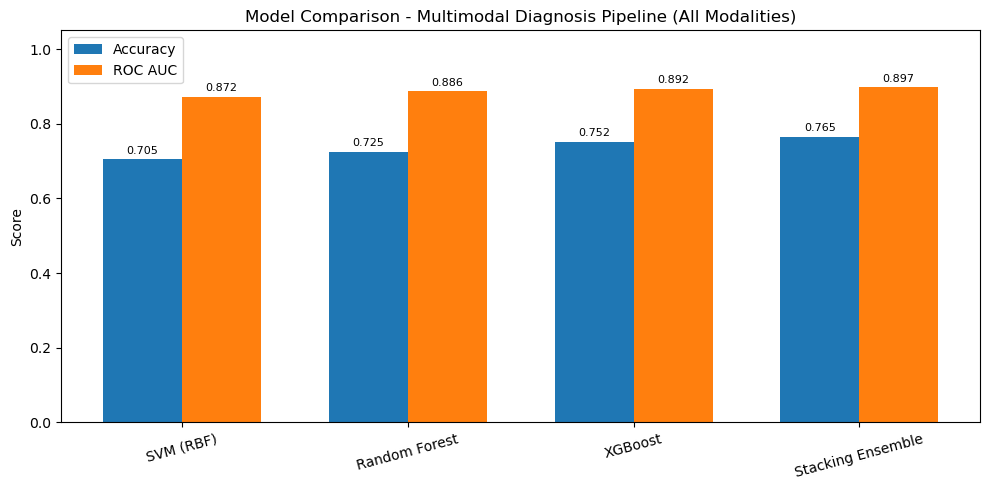

In [7]:

# === Model comparison (Test metrics) ===
plt.figure(figsize=(10,5))
x = np.arange(len(results_df))
w = 0.35
plt.bar(x - w/2, results_df["Test Accuracy"], width=w, label="Accuracy")
plt.bar(x + w/2, results_df["Test ROC-AUC (OvR, macro)"], width=w, label="ROC AUC")
plt.xticks(x, results_df["Model"], rotation=15)
for i, v in enumerate(results_df["Test Accuracy"]):
    plt.text(i - w/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=8)
for i, v in enumerate(results_df["Test ROC-AUC (OvR, macro)"]):
    plt.text(i + w/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=8)
plt.ylim(0, 1.05); plt.ylabel("Score"); plt.title("Model Comparison - Multimodal Diagnosis Pipeline (All Modalities)"); plt.legend()
plt.tight_layout(); plt.savefig(PLOTDIR / "model_comparison_test.png", dpi=200); plt.show()


Best by CV macro AUC: XGBoost
Selected 60 features saved.


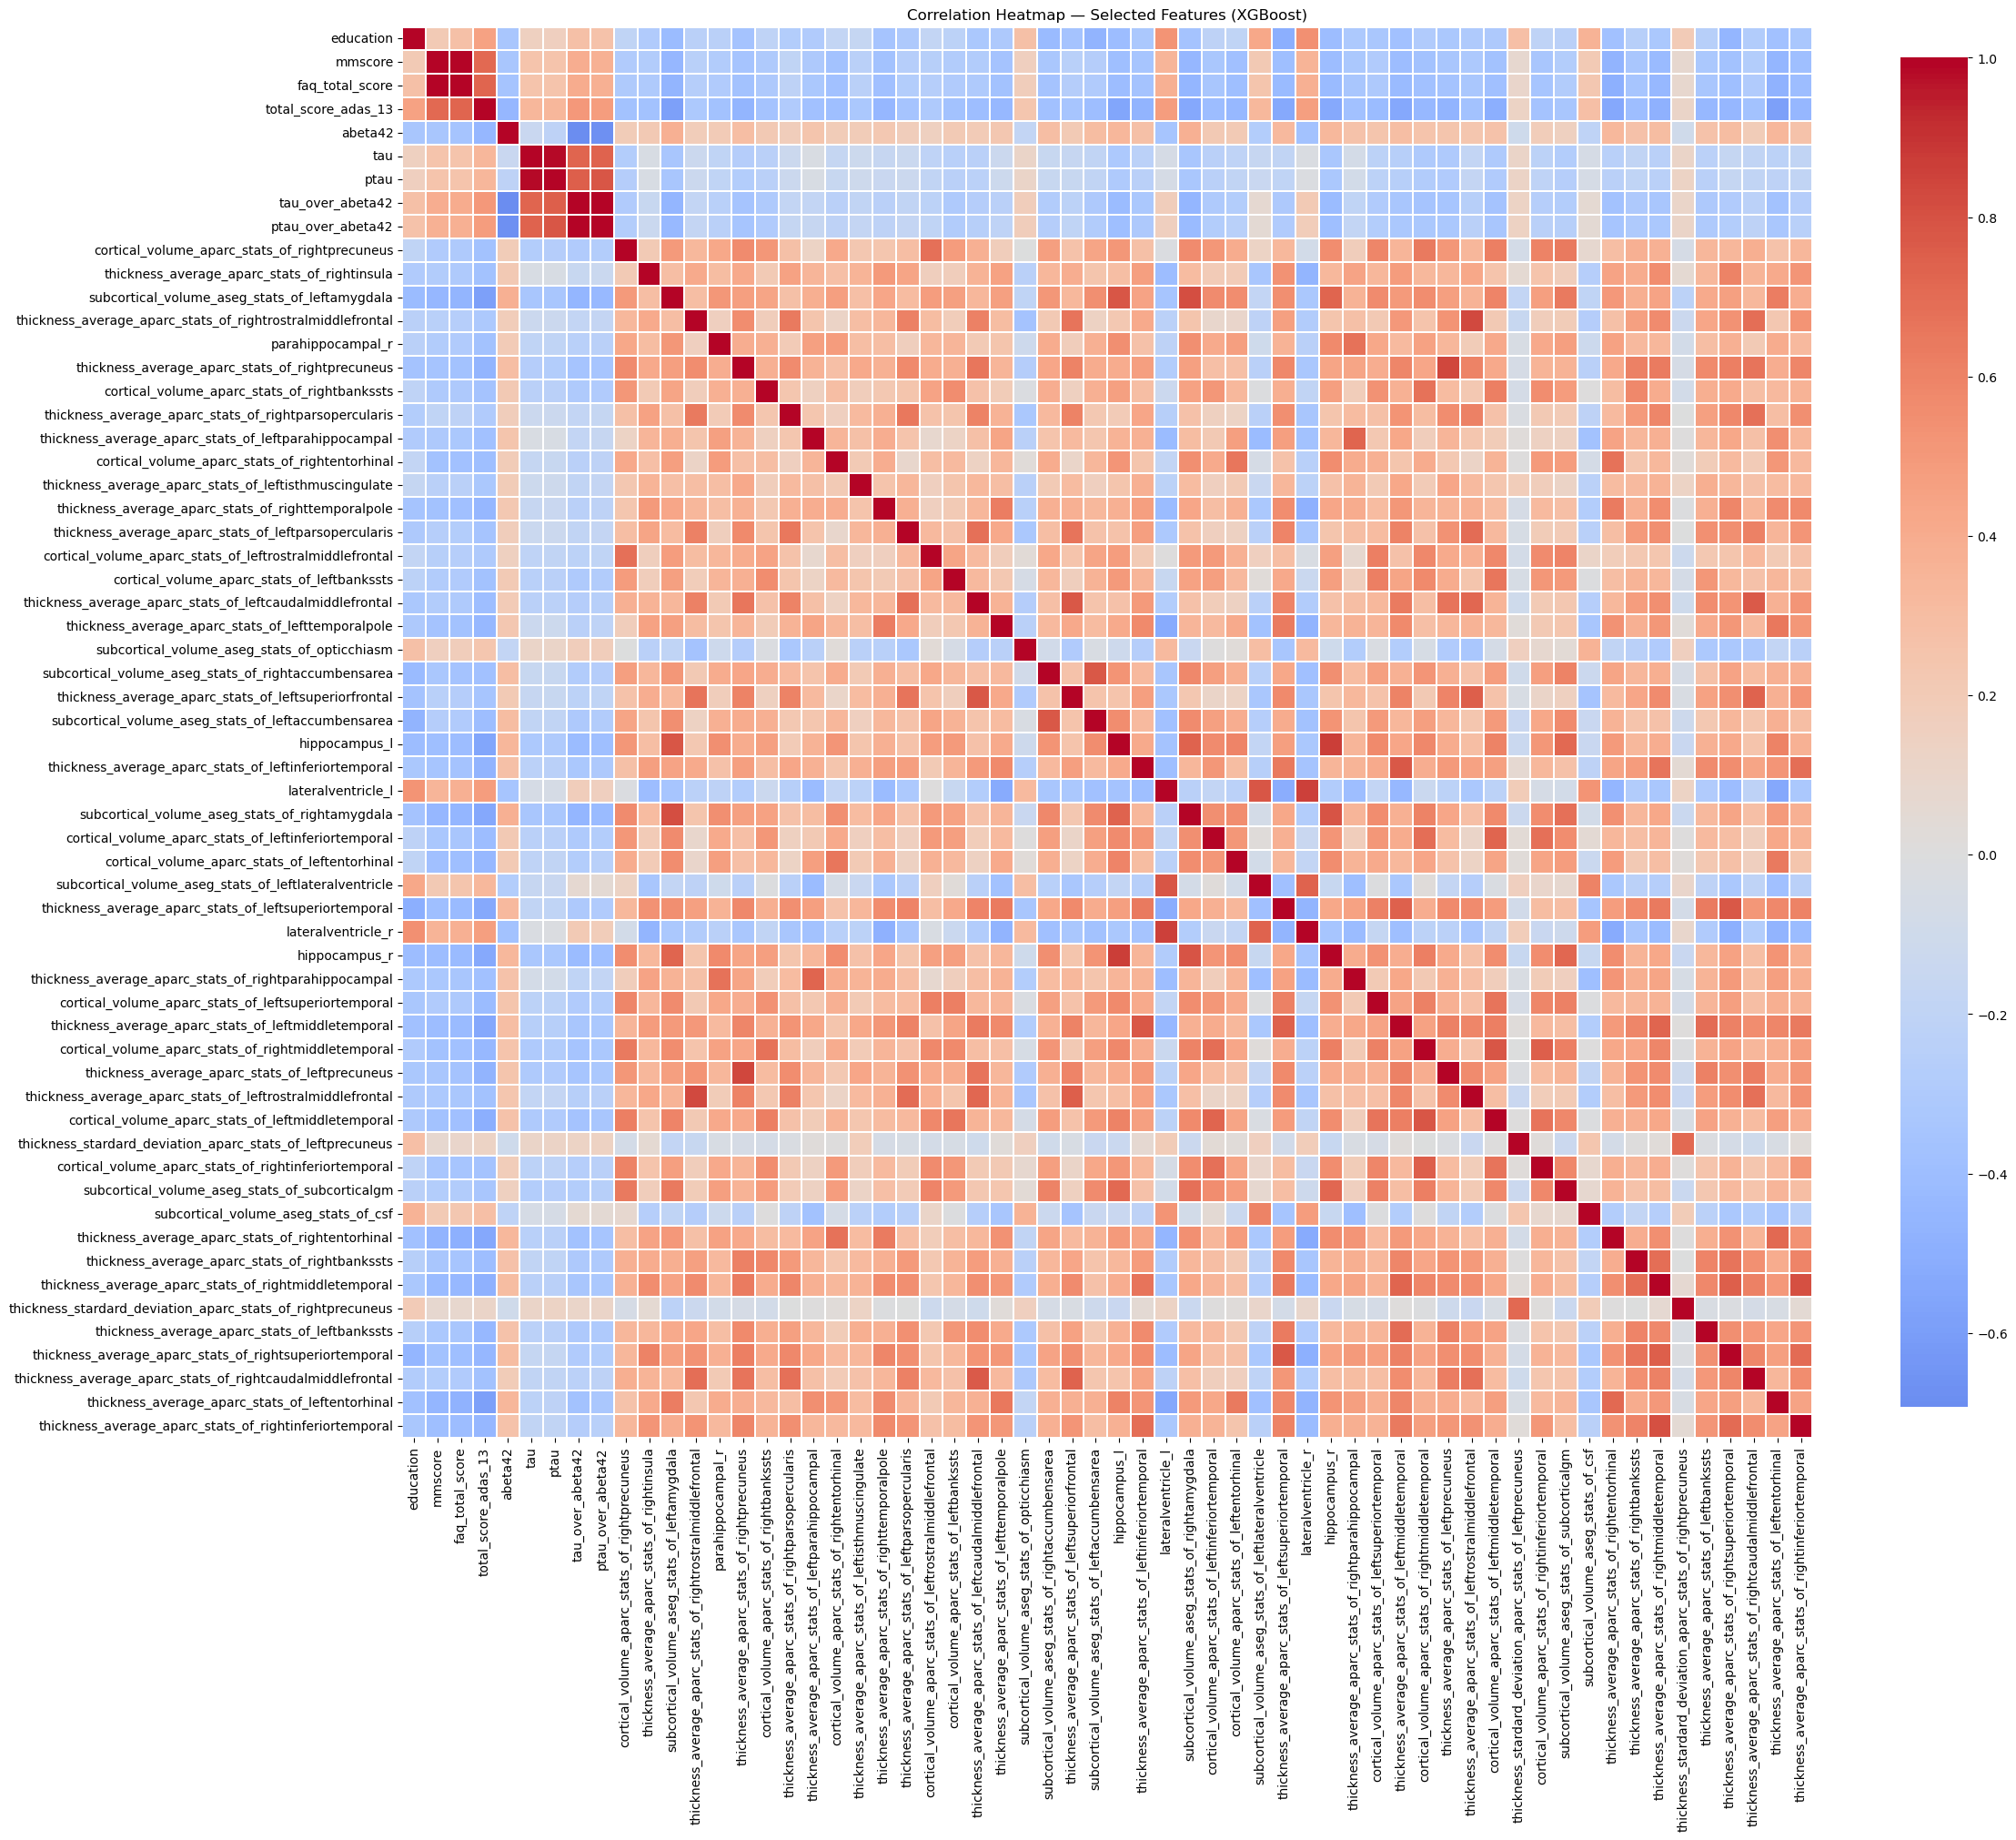

In [8]:

# === After CV: refit on full 80% train to pull selected features from best model (by CV macro AUC) ===
best = results_df.sort_values("CV ROC-AUC (OvR, macro)", ascending=False).iloc[0]["Model"]
print("Best by CV macro AUC:", best)
best_pipe = trained[best]

sel = best_pipe.named_steps["anova"]
mask = sel.get_support()
selected_cols = X_train.columns[mask].tolist()

pd.Series(selected_cols, name="Selected_Features").to_csv(OUTDIR / f"{best.replace(' ','_')}_selected_features.csv", index=False)
print(f"Selected {len(selected_cols)} features saved.")

# Correlation heatmap (train set only)
sel_df = X_train[selected_cols].copy()
corr = sel_df.corr().replace([np.inf, -np.inf], np.nan).fillna(0.0)
N = len(selected_cols)
plt.figure(figsize=(max(10, 0.4*N), max(8, 0.4*N)))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=0.3, cbar_kws={"shrink": .7})
plt.title(f"Correlation Heatmap — Selected Features ({best})")
plt.tight_layout()
plt.savefig(PLOTDIR / f"{best.replace(' ','_')}_selected_features_corr.png", dpi=200, bbox_inches="tight")
plt.show()
